#Introduction

In this Jupyter notebook, I present my approach to the recent Kaggle competition, [Facebook Recruiting IV: Human or Robot?](https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot). The main idea was to treat the modeling problem as somewhat of a text classification problem by sorting the bid data for each bidder in chronological order and using this sorted bid data as a text-based "fingerprint" of the bidder's activities. In addition to this, I computed some numerical features for the time differences between bids and the unique counts of the different entries. The final model ended up being a bag of 15 XGBoost models on a sparse matrix of tfidf-vectorized text features concatenated with scaled numerical features.

# Libraries
For the most part, I used Python standard libraries and the scientific Python libraries available in the Anaconda distribution (`pandas`, `scikit-learn`, `scipy` and `numpy`). The only slightly more exotic library is `XGBoost`. For installing `XGBoost` on Windows, [these](https://www.kaggle.com/c/otto-group-product-classification-challenge/forums/t/13043/run-xgboost-from-windows-and-python) instructions by Alejandro Simkievich and [this](https://github.com/dmlc/xgboost/tree/master/windows) repository on `XGBoost`'s Github profile were helpful.


In [1]:
import pandas as pd
import re
import gc
import numpy as np
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.externals import joblib
import xgboost as xgb

# Feature engineering
First, we read the bid data:

In [2]:
df_bids = pd.read_csv('data/bids.csv')

Eventually, we will tokenize the bid information on spaces, so we remove any additional spaces from the data.

In [3]:
df_bids = df_bids.replace({' ': ''}, regex = True) #remove spaces

A key part of the approach is dealing with the bids in chronological order. Hence, we sort the bids in ascending order of bidder_ids and time.

In [4]:
df_bids_sorted = df_bids.sort(['bidder_id', 'time'], ascending = [True, True])

Then we initialize a `bids`-dataframe where the aggregated bid information for each bidder_id will be gathered.

In [5]:
#dataframe for aggregated bid data
bids = pd.DataFrame(data = df_bids_sorted['bidder_id'].unique(), columns = ['bidder_id'],
                    index = df_bids_sorted['bidder_id'].unique())

As a first entry into the `bids`-dataframe, we count the number of auctions for each bidder_id.

In [6]:
#auction counts                  
counts = df_bids_sorted.groupby('bidder_id')['bidder_id'].agg('count')
bids['auction_count_num'] = counts

Then, we compute the time differences between bids into the `df_bids_sorted`-dataframe. These time differences are included in both numeric and string form. I noticed that there were some time differences that occur quite frequently, and a text processing of time differences should be able to identify these types of patterns in the data.

In [7]:
timediff = df_bids_sorted.groupby('bidder_id')['time'].diff()
timediff_str = timediff.astype(str).fillna('')
df_bids_sorted['timediff_num'] = timediff
df_bids_sorted['timediff'] = timediff_str

In the following, the main aggregation step for the bid data is performed. For each column, the data is first converted into slightly more readable form. For example for urls the data is transformed from the form `0esea7scvgr82he` to the form `url_0esea7scvgr82he`. This was done to make the different entries more identifiable in the case of evaluating feature importances, but in the end this was not utilized to any significant extent. The entries for each bidder were concatenated with a space-delimiter to generate the aggregated text data. The result is a long string of space-delimited entries for each column. E.g. for the device-column, we can have a string of the type `device_phone167 device_phone172 device_phone167` etc. 

In addition to generating the concatenated text data, the number of unique entries was also computed for each column and bidder. Throughout this notebook, we add a `_text`-suffix to text columns and a `_num`-suffix to numerical columns. This allows for the two types of columns to be selected with regular expressions later on.

In [8]:
#turn feature sequences into text
text_cols = ['auction', 'merchandise', 'device', 'timediff', 'country', 'ip', 'url']
for var in text_cols:
    df_bids_sorted[var] = var + "_" + df_bids_sorted[var].fillna("")
    text_str = var + '_text'
    count_str = var + '_nunique_num'
    bids[text_str] = df_bids_sorted.groupby('bidder_id')[var].apply(lambda x: "%s" % ' '.join(x))
    bids[count_str]  = df_bids_sorted.groupby('bidder_id')[var].nunique()

One idea I had was that the distribution of time differences between bids could be a significant predictor of bot activity. Hence, I computed a number of different descriptive statistics related to the times and time differences. In the following, the min and max times and time differences are computed along with the time difference range, mean, median and the first to ninth deciles.

In [9]:
max_time = df_bids_sorted.groupby('bidder_id')['time'].max()
bids['maxtime_num'] = max_time
min_time = df_bids_sorted.groupby('bidder_id')['time'].min()
bids['mintime_num'] = min_time
max_diff = df_bids_sorted.groupby('bidder_id')['timediff_num'].max()
max_diff = max_diff.fillna(max_diff.mean())
bids['maxdiff_num'] = max_diff
min_diff = df_bids_sorted.groupby('bidder_id')['timediff_num'].max()
min_diff = min_diff.fillna(min_diff.mean())
bids['mindiff_num'] = min_diff
range_diff = max_diff - min_diff
bids['rangediff_num'] = range_diff
mean_diff = df_bids_sorted.groupby('bidder_id')['timediff_num'].mean()
mean_diff = mean_diff.fillna(mean_diff.mean())
bids['meandiff_num'] = mean_diff
median_diff = df_bids_sorted.groupby('bidder_id')['timediff_num'].median()
median_diff = median_diff.fillna(median_diff.mean())
bids['mediandiff_num'] = median_diff
for q in [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]:
    q_string = 'diff_quantile_num_' + str(q).replace('.', '_')
    q_temp = df_bids_sorted.groupby('bidder_id')['timediff_num'].quantile(q)
    q_temp = q_temp.fillna(q_temp.mean())
    bids[q_string] = q_temp

This completes the bid aggregation step. After this, we read the `train`- and `test`-data and merge it with the bid data.

In [10]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_combo = df_train.append(df_test)
df_combo['address_text'] = 'address_' + df_combo['address'].fillna('')
df_combo['account_text'] = 'account_' + df_combo['payment_account'].fillna('')
df_combo = df_combo.merge(bids, how = 'left', left_on = ['bidder_id'], right_on = ['bidder_id'])

We delete the redundant dataframes and run garbage collection.

In [11]:
del df_train
del df_test
del df_bids
del df_bids_sorted
del bids
gc.collect();

Using regular expressions, the text and numeric columns are identified. For missing values in numeric columns, we fill in the column mean; for missing values in text columns, we fill in an empty string.

In [12]:
num_cols = filter(re.compile('num').search, df_combo.columns)
text_cols = filter(re.compile('text').search, df_combo.columns)
for col in num_cols:
    df_combo[col] = df_combo[col].fillna(df_combo[col].mean())
for col in text_cols:
    df_combo[col] = df_combo[col].fillna('')

Now, we split the `df_combo`-dataframe into train and test data. First, we grab the columns for the test data and check that the order matches that in the sample submission.

In [13]:
sample = pd.read_csv('submissions/sampleSubmission.csv')
test_dat = df_combo[df_combo.bidder_id.isin(sample.bidder_id)]
#test
print (sample.bidder_id.values==test_dat['bidder_id'].values).all()

True


We put the numeric columns into matrices `xtrain` and `xtest`. The processed sparse text frequency matrices will then be concatenated to them. We will also keep track of the feature names for model interpretation.

In [14]:
train_dat = df_combo[~pd.isnull(df_combo.outcome)]
y = train_dat.outcome.values
xtrain = train_dat[num_cols].values
xtest = test_dat[num_cols].values
col_names = num_cols

The data is scaled using `scikit-learn`'s MinMaxScaler. We use the MinMaxScaler as it leads to non-negative values, which is useful later on as `scikit-learn`'s `chi2`-feature selection function only works on non-negative data.

In [15]:
sc = MinMaxScaler().fit(np.vstack((xtrain, xtest)))
xtrain = sc.transform(xtrain)
xtest = sc.transform(xtest)

As a final step before text processing, the numeric `xtrain`- and `xtest`-matrices are converted into sparse matrices to prepare for the concatenation with tfidf-matrices later on.

In [16]:
xtrain = sparse.csr_matrix(xtrain)
xtest = sparse.csr_matrix(xtest)

# Text processing
The text columns are processed using the tfidf-vectorizer in `scikit-learn`. First we define a custom tokenizer-function that only split on spaces:

In [17]:
def tokens(x):
    return x.split(' ')

We use slightly different tfidf-parameters for the different columns. These are stored in a `text_params`-dictionary.

In [18]:
text_params = {}
text_params['address_text'] = {'include':False}
text_params['account_text'] = {'include':False}
text_params['auction_text'] = {'include':True, 'mindf':5, 'ngram':(1,3), 'token':'tokens'}
text_params['merchandise_text'] = {'include':True, 'mindf':5, 'ngram':(1,3), 'token':'tokens'}
text_params['device_text'] = {'include':True, 'mindf':5, 'ngram':(1,3), 'token':'tokens'}
text_params['timediff_text'] = {'include':True, 'mindf':1, 'ngram':(1,1), 'token':'tokens'}
text_params['country_text'] = {'include':True, 'mindf':5, 'ngram':(1,3), 'token':'tokens'}
text_params['ip_text'] = {'include':True, 'mindf':1, 'ngram':(1,1), 'token':'nottokens'}
text_params['url_text'] = {'include':True, 'mindf':5, 'ngram':(1,3), 'token':'tokens'}

The parameter choices were based on some brief univariate tests of `auc`-performance. The `address` and `account`-fields were not found to be very useful and were dropped from the data. 

For all columns except for the timediff, the ngrams parameter is (1,3), i.e. we also consider bigrams and trigrams in addition to single tokens. For these columns, we should thereby be able to identify some sequential structure in the bid data. 

Interestingly, the `ip_text`-column had an improved `auc` when using the default tfidf-tokenizer instead of our custom `tokens`-tokenizer. The default-tokenizer also splits on punctuation and thereby splits the ip into its sub-addresses, which turned out to be useful for this modeling problem. For the other text columns, we use the space-delimited `tokens`-tokenization.

With the following code snippet, the text columns were vectorized and concatenated to the `xtrain`- and `xtest`-matrices:

In [19]:
for col in text_cols:
    if not text_params[col]['include']:
        continue
    else:
        if text_params[col]['token'] == 'tokens':
            vect = TfidfVectorizer(tokenizer = tokens, min_df = text_params[col]['mindf'],
                                   ngram_range = text_params[col]['ngram'])
        else:
            vect = TfidfVectorizer(min_df = text_params[col]['mindf'],
                                   ngram_range = text_params[col]['ngram'])
        documents = df_combo[col].values
        vect.fit(documents)
        col_names = col_names + vect.get_feature_names()
        xtr_tmp = vect.transform(train_dat[col].values)
        xte_tmp = vect.transform(test_dat[col].values)
        xtrain = sparse.hstack((xtrain, xtr_tmp))
        xtest = sparse.hstack((xtest, xte_tmp))

Finally, we pickle and save the `xtrain`-matrix and the `y`-vector. These objects are required for running the grid search script `hyperopt_xgb.py`.

In [20]:
joblib.dump(xtrain, 'data/xtrain.pkl', compress = 3);
joblib.dump(y, 'data/y.pkl', compress = 3);

# Model
For the final model, we perform a univariate `chi2`-feature selection to choose the top-25% of features. Then we fit 15 XGBoost-models to the data, where the only difference between the bagged models is the random seed. For the final submission, we take the average of the 15 models in the bag.

In [21]:
#feature selection
feats_25 = SelectPercentile(chi2, 25).fit(xtrain, y)
xtrain = feats_25.transform(xtrain)
xtest = feats_25.transform(xtest)

clf = xgb.XGBClassifier(objective = 'binary:logistic',
                            learning_rate = 0.05,
                            max_depth = 5,
                            nthread = 8,
                            seed = 42,
                            subsample = 0.4,
                            colsample_bytree = 0.7,
                            min_child_weight = 1,
                            n_estimators = 100,
                            gamma = 0.15, silent = True)

#bag of 15 models
rounds = 15
preds_mat = np.zeros((len(sample.index), rounds))
for i in range(rounds):
    clf.set_params(seed = i + 1)
    clf.fit(xtrain, y)
    preds_tmp = clf.predict_proba(xtest)[:, 1]
    preds_mat[:, i] = preds_tmp
bagged_preds = preds_mat.mean(axis = 1)
sample.prediction = bagged_preds
sample.to_csv('submissions/facebook_submission.csv', index = False)

This submission should score around 0.93698 on the private leaderboard for a rank of 18th. The hyperparameters were determined through a grid search. In the Github-repository, there is a script called `hyperopt_xgb.py` that shows how this type of search could be performed.

# Model interpretation
To end this notebook, a brief investigation of the feature importances of our model will be performed. To access the feature importances of an `xgboost`-model, we have to use the default python interface instead of the scikit-learn interface we have used so far. First, we exclude all the features that were not selected by our univariate feature selector `feats_25`:

In [22]:
col_names = np.array(col_names)[feats_25.get_support()]

Then we fit an `xgboost`-model using the standard python interface:

In [23]:
xgb_params = {'objective': 'binary:logistic',
              'eta': 0.05,
              'max_depth': 5,
              'seed': 42,
              'subsample': 0.4,
              'colsample_bytree': 0.7,
              'min_child_weight': 1,
              'gamma': 0.15}
num_round = 100
dtrain = xgb.DMatrix(xtrain, label = y)
booster = xgb.train(xgb_params, dtrain, num_round)

Then we grab the feature importances from the booster and place them in a dataframe:

In [24]:
importance = booster.get_fscore()
df_imp = pd.DataFrame(columns = ('feature', 'importance'))
sum_imp = 0
for imp in importance:
    row = col_names[int(imp[1:])], importance[imp]
    df_imp.loc[len(df_imp.index)] = row
    sum_imp += importance[imp]
df_imp['relative_importance'] = df_imp.importance/float(sum_imp)
df_imp.drop(['importance'], 1, inplace = True)
df_imp.sort(columns=['relative_importance'], ascending = False, inplace = True)
df_imp.index = df_imp.feature

We do some further processing of the `df_imp`-dataframe to get the dataframe ready for plotting. We will plot only the 20 most significant features.

In [25]:
pd.options.mode.chained_assignment=None
df_plot = df_imp[:20]
names = {'country':'Country', 'num': 'Numeric', 'timediff': 'Time difference',
         'device':'Device', 'url':'URL', 'ip':'IP address'}
for pattern in sorted(names.keys()):
    df_plot[names[pattern]] = 0
    if pattern == 'ip':
        rows = df_plot.feature.str.isnumeric()
    elif pattern == 'timediff':
        rows = df_plot.feature.str.contains(pattern) & ~df_plot.feature.str.contains('num')
    else:
        rows = df_plot.feature.str.contains(pattern)
    df_plot.loc[rows, names[pattern]] = df_plot.loc[rows, 'relative_importance']
df_plot = df_plot.drop(['feature', 'relative_importance'], 1)

Finally, we plot the feature importances:

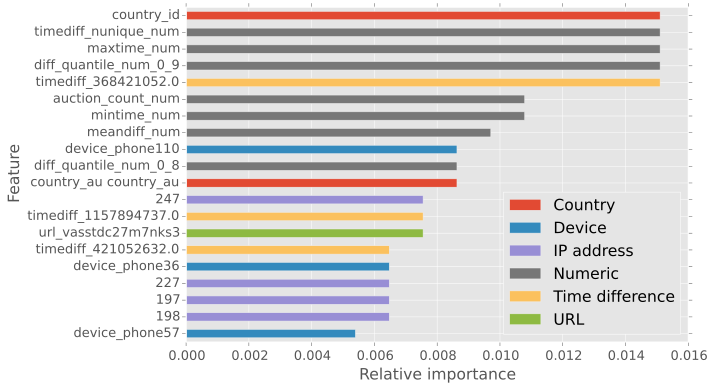

In [26]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'font.size': 13})
matplotlib.rcParams['figure.figsize'] = 9, 6
ax = df_plot.plot(kind='barh', stacked = True)
ax.invert_yaxis()
plt.xlabel('Relative importance')
plt.ylabel('Feature');

As can be seen in the graph above, a wide variety of our engineered features emerge as significant in the final xgboost-model. For example, time intervals of exactly 421052632, 1157894737 and 368421052 between bids emerge as significant features. The numeric variables (247, 221, 197 and 198) are parts of IP-addresses. The country codes `id` and `au` also emerge as significant. Of our numerical variables, the auction counts and a few descriptive statistics for the time difference distributions also emerge as significant.